# Time projectors
These are used to extend a pathway to cover later times. For instance, if you know the CO2 pathway prior to 2030, can you estimate what it will look like up until 2100? Currently there are three methods available:

* Extend Latest Time Quantile
* Extend RMS Closest
* Linear extender

In [1]:
# Basic setup
import matplotlib.pyplot as plt
import pandas as pd

import silicone.time_projectors as timeproj
from silicone.utils import download_or_load_sr15


Bad key "text.kerning_factor" on line 4 in
c:\users\rlamboll\appdata\local\continuum\anaconda3\envs\silicone-5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


<IPython.core.display.Javascript object>

In [2]:
# Import the data to use
valid_model_ids = [
    "MESSAGE*",
    "AIM*",
    "C-ROADS*",
    "GCAM*",
    "WITCH*",
]
sr15_data = download_or_load_sr15("./sr15_scenarios.csv", valid_model_ids)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file sr15_scenarios.csv


## Extend Latest Time Quantile
This applies the same logic as the EQW but extends the time period of the selected emission variable to the latest time in the infiller database. (If you only want to infill a shorter time, you can pre-filter the infiller database.) 

In [3]:
# Select a subset of data to use as the infiller database. Note we only need one variable in the data
lead = "Emissions|CO2"
sr15_data_quantile = sr15_data.filter(model=["WITCH-GLOBIOM 4.2"], variable=lead)
sr15_data_quantile.head()

,model,scenario,region,variable,unit,year,value
0,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2005,31743.82847
1,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2010,34057.08892
2,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2015,35659.76850
3,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2020,37303.32932
4,WITCH-GLOBIOM 4.2,ADVANCE_2020_1.5C-2100,World,Emissions|CO2,Mt CO2/yr,2025,21322.81018


In [4]:
# Use another subset of the data to be infilled.
filler_input = sr15_data.filter(
    model="MESSAGEix-GLOBIOM 1.0",
    scenario="CD-LINKS_NPi2020_1000",
    variable=lead,
)
# Select the times of data we pretend to know
short_filler_data = filler_input.filter(year=[2005, 2010, 2020, 2030])

So we have a dataset up to 2030 and want to extend the CO2 pathway to 2100:

In [5]:
extender = timeproj.ExtendLatestTimeQuantile(sr15_data_quantile)
# Only one argument (the emission name) is needed in derive relationship
filler = extender.derive_relationship(lead)
extension = filler(short_filler_data)

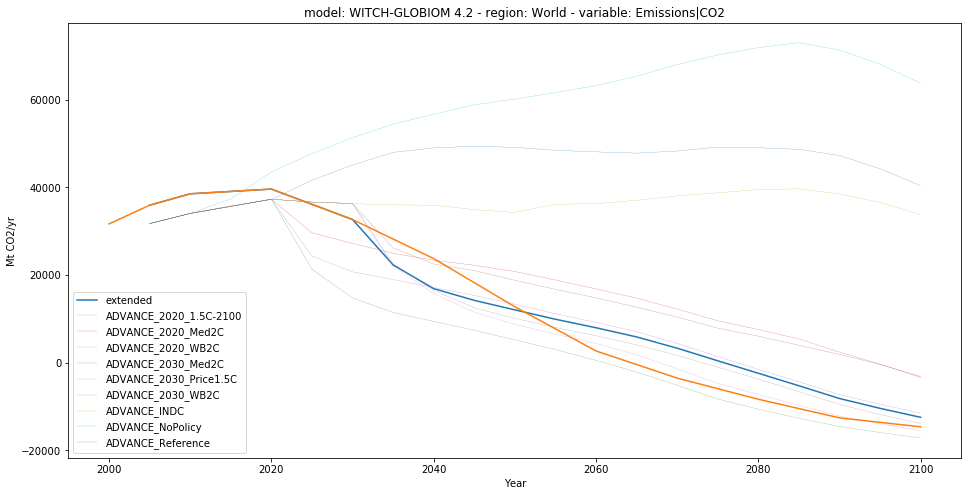

In [6]:
extended_df = short_filler_data.append(extension)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
extended_df.plot(ax=ax, label="extended")
filler_input.plot(ax=ax)
sr15_data_quantile.filter(variable="Emissions|CO2").plot(ax=ax, linewidth=0.2)

As this plot shows, the assumption that the scenario will remain in a constant position relative to the other scenarios does not always hold, and the infilled line takes on one of the strange kinks in the infiller database at 2030. Better results might be obtained if we used scenarios with more similar trajectories.

In [7]:
# Here we use similar scenarios
model_match = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", variable=lead).filter(
    scenario="CD-LINKS_NPi2020_1000", keep=False
)
extender = timeproj.ExtendLatestTimeQuantile(model_match)
# Only one argument (the emission name) is needed in derive relationship
filler = extender.derive_relationship(lead)
extension = filler(short_filler_data)

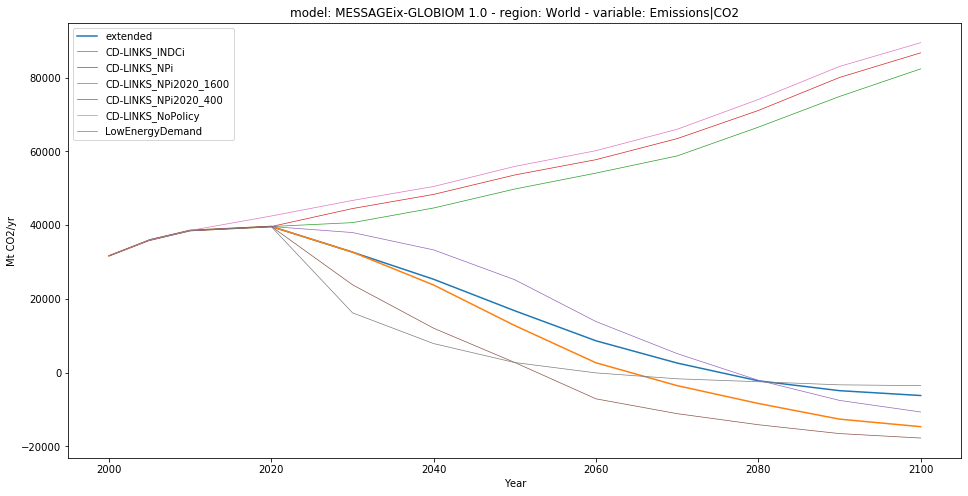

In [8]:
extended_df = short_filler_data.append(extension)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
extended_df.plot(ax=ax, label="extended")
filler_input.plot(ax=ax)
model_match.filter(variable="Emissions|CO2").plot(ax=ax, linewidth=0.7)

Here the lineshape is more consistent in both cases. This parameter can use the same smoothing and weighting functions as the equal quantile walk function, explained in notebook 06.

# Extend RMS Closest 

This applies the same logic as the RMS closest infilling technique. For the reported data, the closest pathway (i.e., the model/scenario combination with the least RMSE) is selected and the data in the missing timesteps is selected from this pathway.

We test this using data that is truncated at 2030 (as above).

In [9]:
short_filler_data.data

,model,scenario,region,variable,unit,year,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2005,35933.06970
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2010,38542.01816
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2020,39615.22255
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2030,32672.15942


In [10]:
extender = timeproj.ExtendRMSClosest(sr15_data_quantile)
# Only one argument (the emission name) is needed in derive relationship
filler = extender.derive_relationship(lead)
extension = filler(short_filler_data)

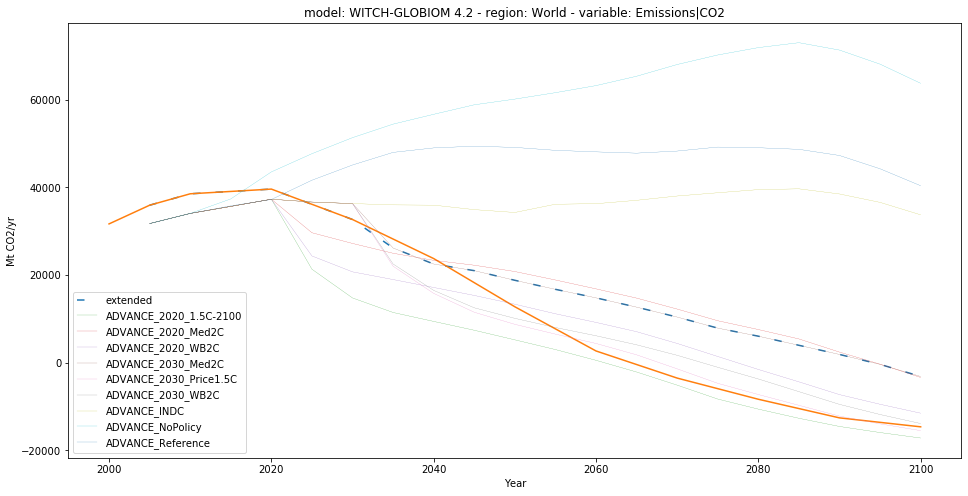

In [11]:
extended_df = short_filler_data.append(extension)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
extended_df.plot(ax=ax, linestyle=(0, (5, 10)), label="extended")
filler_input.plot(ax=ax)
sr15_data_quantile.filter(variable="Emissions|CO2").plot(ax=ax, linewidth=0.2)

We observe that the future timesteps are infilled as desired by selecting future timesteps from the appropriate scenario.

# Linear extender
The linear extender is used when there is a known endpoint in a given year, or when we wish to extend the current data at a known gradient. This is often used to match the data up to a net zero target or to continue the current rate of emissions (with gradient zero) in idealised cases. There is no need to initialise it with a database except to save you from entering the years at which you would like to receive results (which can be entered as an argument in derive_relationship instead).

Once again we will demonstrate with data truncated at 2030. This time we will extend it a net zero at 2050, then project constant zero emissions from there. 

In [12]:
# We will use short_filler_data agaain
variable = "Emissions|CO2"
project2050 = timeproj.LinearExtender()  # No database used here
netzero2050 = project2050.derive_relationship(variable=variable, times=[2040, 2050], year_value=(2050, 0))(short_filler_data)
result2050 = short_filler_data.append(netzero2050)
result2050.data

,model,scenario,region,variable,unit,year,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2005,3.593307e+04
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2010,3.854202e+04
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2020,3.961522e+04
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2030,3.267216e+04
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2040,1.633608e+04
5,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1000,World,Emissions|CO2,Mt CO2/yr,2050,3.637979e-12


We can continue extending this at a constant rate until the end of the century using the same projector with different times options, or to save listing all the years, simply add the database when constructing the projector.

In [13]:
const_proj = timeproj.LinearExtender(sr15_data)
project2100 = const_proj.derive_relationship(variable=variable, gradient=0)(result2050)
result2100 = result2050.append(project2100)

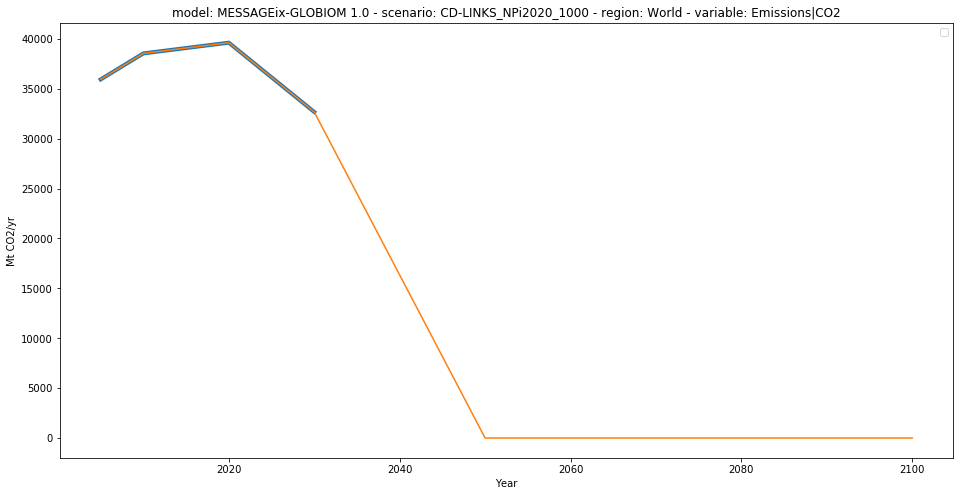

In [14]:
# This has now been extended by two linear trends
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
short_filler_data.plot(ax=ax, linewidth=4)
result2100.plot(ax=ax)